## Домашка (10 баллов)


Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


# Results:

##### 15 layers (only count Dropout, Conv1d, Pooling, Dense):

+ Conv1d - 4
+ Pooling - 4
+ Dense, fully connected (2 parallel) - 4
+ Dropout - 3

##### Requirements:
+ each layer - different parameters +
+ 4 layers - fully connected +
+ 2 layers - parallel +
+ callback - best model (monitor = "f1") +
+ F1 >70% (94%) +

In [1]:
!pip install torch pandas scikit-learn matplotlib

You should consider upgrading via the 'c:\users\nikol\onedrive\desktop\hse_projects\.venv\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv(r"C:\Users\nikol\OneDrive\Desktop\HSE_projects\data\lenta-ru-train.csv", encoding='utf-8')
data.head()

,title,text,topic,topic_label
0,"Инфляция в январе 2006 года составит 2,6 процента","Глава Росстата Владимир Соколин заявил, что в ...",Экономика,0
1,Никита Михалков учредил День российского кино,У российских кинематографистов появится новый...,Культура,3
2,Марко Матерацци вернется в строй к матчу с ЦСКА,"Медицинский штаб миланского ""Интера"" обнародов...",Спорт,1
3,"Определены лауреаты премии ""Книга года""","Премии ""Книга года"" в 13 номинациях вручены на...",Культура,3
4,Гол Роналду со штрафного спас португальцев от ...,Сборная Португалии сыграла вничью с командой И...,Спорт,1


In [4]:
data.dropna(subset=['topic', 'text'], inplace=True)

In [5]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [6]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [7]:
len(vocab)

745739

In [8]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)
len(filtered_vocab)

68212

In [9]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, word2id, MAX_LEN, texts, targets):
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


In [12]:
MAX_LEN = 200

In [13]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [14]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [15]:
training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True)

In [16]:
valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True)

In [17]:
class EarlyStopping:
    def __init__(self, delta):
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, f1_score, model):
        if self.best_score is None:
            self.best_score = f1_score
            self.save_checkpoint(f1_score, model)
        elif f1_score < self.best_score - self.delta:
            self.early_stop = True
        else:
            self.best_score = f1_score
            self.save_checkpoint(f1_score, model)

    def save_checkpoint(self, f1_score, model):
        print(f'Saving best model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_score = f1_score

In [18]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    epoch_loss = []
    epoch_f1 = []
    
    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        f1 = f1_score(y_true, preds, average="micro")
        epoch_f1.append(f1)
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
    
    mean_f1 = np.mean(epoch_f1)

    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()

            epoch_loss.append(loss.item())
            f1 = f1_score(y_true, preds, average="micro")
            epoch_f1.append(f1)
            
    return np.mean(epoch_f1)

In [19]:
class MyModel(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.MAX_LEN = 200 
        self.IN_100_CH = self.EMB_DIM 
        self.OUT_64_CH = 64 
        self.OUT_32_CH = 32
        self.OUT_16_CH = 16

        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.conv_1 = nn.Conv1d(self.IN_100_CH, 
                              self.OUT_64_CH, 
                              kernel_size=20, 
                              stride=2)
        self.drop_1 = nn.Dropout(0.1)
        self.pool_1 = nn.MaxPool1d(kernel_size=10, stride=2)

        self.conv_2 = nn.Conv1d(self.OUT_64_CH, 
                              self.OUT_32_CH, 
                              kernel_size=10, 
                              stride=2)
        self.drop_2 = nn.Dropout(0.2)
        self.pool_2 = nn.MaxPool1d(kernel_size=5, stride=2)

        self.conv_3 = nn.Conv1d(self.OUT_32_CH, 
                              self.OUT_64_CH, 
                              kernel_size=5, 
                              stride=1)
        self.drop_3 = nn.Dropout(0.3)
        self.pool_3 = nn.MaxPool1d(kernel_size=2, stride=1)
        self.conv_4 = nn.Conv1d(self.OUT_64_CH, 
                              self.OUT_32_CH, 
                              kernel_size=1, 
                              stride=1)
        self.pool_4 = nn.MaxPool1d(kernel_size=1, stride=1)
        
        self.relu = nn.ReLU() 
        
        self.fc_1 = nn.Linear(self.OUT_32_CH, self.OUT_64_CH)
        self.fc_2 = nn.Linear(self.OUT_64_CH, self.OUT_16_CH)
        self.fc_3 = nn.Linear(self.OUT_64_CH, self.OUT_16_CH)
        self.fc_4 = nn.Linear(self.OUT_32_CH, output_dim)

        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        convoluted = self.relu(self.conv_1(embedded))
        dropped = self.drop_1(convoluted)
        pooled = self.pool_1(dropped)

        convoluted_2 = self.relu(self.conv_2(pooled)) 
        dropped_2 = self.drop_2(convoluted_2)
        pooled_2 = self.pool_2(dropped_2)

        convoluted_3 = self.relu(self.conv_3(pooled_2))
        dropped_3 = self.drop_3(convoluted_3)
        pooled_3 = self.pool_3(dropped_3)

        convoluted_4 = self.relu(self.conv_4(pooled_3))
        pooled_4 = self.pool_4(convoluted_4)

        hidden_1 = torch.flatten(pooled_4, 1, -1) 
        hidden_2 = self.relu(self.fc_1(hidden_1)) 

        hidden_3 = self.relu(self.fc_2(hidden_2))
        hidden_4 = self.relu(self.fc_3(hidden_2))
        
        parallel = torch.cat((hidden_3, hidden_4), dim=1)

        dense_outputs = self.fc_4(parallel) 
        outputs=self.act(dense_outputs) 
        
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = MyModel(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [20]:
f1s = []
f1s_eval = []

earlystopping = EarlyStopping(delta=0.001)

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl_f1 = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl_f1)
    f1s_eval.append(evl_f1)

    earlystopping(evl_f1, model)
    if earlystopping.early_stop:
        print("F1 stopped increasing. Stopping training")
        earlystopping.save_checkpoint(evl_f1, model)
        break

0
Loss: 1.3443636059761048; F1 measure: 0.39453125
Loss: 1.1072607588768006; F1 measure: 0.50966796875
Loss: 0.948824396332105; F1 measure: 0.5922265625
Loss: 0.8305940137058496; F1 measure: 0.6525
Loss: 0.741199276983738; F1 measure: 0.6962578125
Loss: 0.6703850431491931; F1 measure: 0.7294205729166666
Loss: 0.6154280970352036; F1 measure: 0.7547712053571428
Eval -  0.9133168743372216
Saving best model ...
1
Loss: 0.20654176332056523; F1 measure: 0.93484375
Loss: 0.2042227778956294; F1 measure: 0.93458984375
Loss: 0.20175948351621628; F1 measure: 0.9353645833333334
Loss: 0.20082653298974038; F1 measure: 0.935439453125
Loss: 0.20117507530748843; F1 measure: 0.9348046875
Loss: 0.19788729875038066; F1 measure: 0.9354166666666667
Loss: 0.19439376748033932; F1 measure: 0.9363392857142857
Eval -  0.9338008682396607
Saving best model ...
2
Loss: 0.11621247254312038; F1 measure: 0.9612109375
Loss: 0.1159632083773613; F1 measure: 0.9608984375
Loss: 0.1167177789285779; F1 measure: 0.96072916666

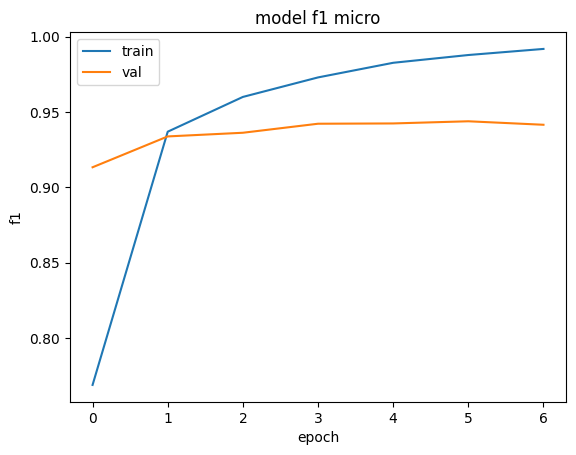

In [21]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
max(f1s_eval)

0.9438585299575821